In [1]:
from utz import *
from utz import plots
import plotly.graph_objects as go
import plotly.express as px
from nj_crashes.paths import PLOTS_DIR, RUNDATE_PATH, DB_URI
from nj_crashes.utils import normalized_ytd_days
save = partial(plots.save, bg='white')

In [2]:
totals = read_sql_table("totals", DB_URI).set_index('year')
crashes = read_sql_table("crashes", DB_URI)

totals

,accidents,injuries,fatalities
year,,,
2008,555,414,590
2009,550,352,584
2010,530,366,556
2011,586,517,627
2012,553,382,589
2013,508,393,542
2014,523,345,556
2015,522,374,562
2016,570,398,602


In [3]:
crashes

,ACCID,CCODE,CNAME,MCODE,MNAME,HIGHWAY,LOCATION,FATALITIES,INJURIES,STREET,FATAL_D,FATAL_P,FATAL_T,FATAL_B,dt
0,1703,01,Atlantic,0102,Atlantic City,446,State/Interstate Authority 446 S MP 1,1.0,1.0,None,NaN,NaN,NaN,NaN,2008-01-01 00:35:00
1,1681,09,Hudson,0910,Union City,None,Bergenline Ave S MP 0 at 6th St,1.0,NaN,Bergenline Ave,NaN,NaN,NaN,NaN,2008-01-01 04:11:00
2,1659,04,Camden,0415,Gloucester Twsp,42,State Highway 42 N MP 8.2,1.0,1.0,None,NaN,NaN,NaN,NaN,2008-01-01 06:46:00
3,1661,20,Union,2004,Elizabeth City,624,County 624 W MP 2.2 at Ikea Dr,1.0,1.0,None,NaN,NaN,NaN,NaN,2008-01-01 12:29:00
4,1811,07,Essex,0716,Nutley Town,648,County 648 E MP .87 at Franklin Ave,1.0,NaN,None,NaN,NaN,NaN,NaN,2008-01-01 18:53:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,12676,08,Gloucester,0811,Monroe Twsp,655,County 655 (Spur (County Routes Only)),1.0,NaN,None,1.0,0.0,0.0,0.0,2023-09-07 07:46:00
8780,12677,18,Somerset,1805,Branchburg Twsp,202,State Highway 202,1.0,NaN,None,1.0,0.0,0.0,0.0,2023-09-08 07:38:00
8781,12680,12,Middlesex,1225,Woodbridge Twsp,1,State Highway 1,1.0,NaN,None,1.0,0.0,0.0,0.0,2023-09-08 12:45:00
8782,12678,04,Camden,0408,Camden City,None,Lansdowne Ave,1.0,NaN,Lansdowne Ave,1.0,0.0,0.0,0.0,2023-09-09 23:34:00


In [4]:
with open(RUNDATE_PATH, 'r') as f:
    rundate = to_dt(json.load(f)['rundate'])

rundate_ytd_days = normalized_ytd_days(rundate)
rundate_str = rundate.strftime('%Y-%m-%d')
cur_month = rundate.strftime('%Y-%m')
cur_month_dt = to_dt(cur_month).tz_localize(rundate.tz)
cur_year = cur_month_dt.year
cur_year_dt = to_dt(f'{cur_year}').tz_localize(rundate.tz)
nxt_year_dt = to_dt(f'{cur_year + 1}').tz_localize(rundate.tz)
print(rundate)
print(cur_month_dt)
print(cur_year_dt)
print(nxt_year_dt)

2023-09-11 10:00:02
2023-09-01 00:00:00
2023-01-01 00:00:00
2024-01-01 00:00:00


## YTD Calculations

In [5]:
all_days = pd.DataFrame([
    dict(Days=days, Text=(to_dt(f'{2022}') + pd.Timedelta(days=days-1)).strftime('%b %-d'))
    for days in range(1, 366)
]).set_index('Days')
all_days

,Text
Days,
1,Jan 1
2,Jan 2
3,Jan 3
4,Jan 4
5,Jan 5
...,...
361,Dec 27
362,Dec 28
363,Dec 29


In [6]:
def fill_all_days(df):
    df = df.set_index('Days').merge(
        all_days,
        left_index=True,
        right_index=True,
        how='right',
    )
    years = df.Year.dropna().unique()
    if len(years) > 1:
        raise ValueError(f"Years: {years}")
    [year] = years
    if year == rundate.year:
        df = df[df.index < rundate_ytd_days]
    df = df.drop(columns='Year')
    df['YTD Deaths'] = df['YTD Deaths'].fillna(method='ffill').fillna(0).astype(int)
    return df    

In [7]:
ytds = crashes[['dt', 'FATALITIES']].copy()
ytds['Year'] = ytds.dt.dt.year
ytds['Days'] = ytds.dt.apply(normalized_ytd_days)
ytds = (
    ytds
    .groupby('Year', group_keys=False)
    .apply(lambda df: (
        df.assign(**{
            'YTD Deaths': df.FATALITIES.cumsum().astype(int)
        })
    ))
)
ytds = (
    ytds[['Year', 'Days', 'YTD Deaths']]
    .groupby(['Year', 'Days'])
    .max()
    .reset_index()
)

ytds = ytds.groupby('Year').apply(fill_all_days).reset_index()
ytds

/tmp/ipykernel_1963/3938185411.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['YTD Deaths'] = df['YTD Deaths'].fillna(method='ffill').fillna(0).astype(int)
/tmp/ipykernel_1963/3938185411.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['YTD Deaths'] = df['YTD Deaths'].fillna(method='ffill').fillna(0).astype(int)
/tmp/ipykernel_1963/3938185411.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['YTD Deaths'] = df['YTD Deaths'].fillna(method='ffill').fillna(0).astype(int)
/tmp/ipykernel_1963/3938185411.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['YTD Deaths'] = df['YTD Deaths'].fillna(method='ffill').fillna

,Year,Days,YTD Deaths,Text
0,2008,1,5,Jan 1
1,2008,2,6,Jan 2
2,2008,3,8,Jan 3
3,2008,4,10,Jan 4
4,2008,5,12,Jan 5
...,...,...,...,...
5723,2023,249,395,Sep 6
5724,2023,250,397,Sep 7
5725,2023,251,399,Sep 8
5726,2023,252,400,Sep 9


In [8]:
cur_ytds = ytds[ytds.Year == rundate.year]
cur_ytd_deaths = 0 if cur_ytds.empty else cur_ytds.iloc[-1]['YTD Deaths']

prv_ytd = ytds[ytds.Year == rundate.year - 1]
prv_end_deaths = prv_ytd.iloc[-1]['YTD Deaths']
prv_ytd_deaths = prv_ytd[prv_ytd.Days == rundate_ytd_days].iloc[-1]['YTD Deaths']
prv_roy_ratio = prv_end_deaths / prv_ytd_deaths

projected_records_total = int(cur_ytd_deaths * prv_roy_ratio)
prv_ytd_ratio = cur_ytd_deaths / prv_ytd_deaths
pct_change = (prv_ytd_ratio - 1) * 100

print(f'Current YTD Deaths ({rundate_str}): {cur_ytd_deaths}')
print(f'Previous year YTD Deaths ({rundate_str}): {prv_ytd_deaths}')
print(f'Projected {rundate.year} total: {projected_records_total}')
print(f'{pct_change:.1f}% change')

projected_records_total, cur_ytd_deaths, prv_ytd_deaths, prv_roy_ratio

Current YTD Deaths (2023-09-11): 401
Previous year YTD Deaths (2023-09-11): 497
Projected 2023 total: 559
-19.3% change


(559, 401, 497, 1.3963782696177063)

In [9]:
rundate_year_frac = (rundate - cur_year_dt) / (nxt_year_dt - cur_year_dt)
year_frac = (cur_month_dt - cur_year_dt) / (nxt_year_dt - cur_year_dt)
rundate_year_frac, year_frac

(0.6942923008625064, 0.6657534246575343)

### Color utilities

In [10]:
from utz.colors import RGB, color_interp, colors_lengthen, swatches
from nj_crashes.colors import get_colors, gridcolor, px_colors

years = totals.index.unique()
colors = get_colors(len(years))
black, red, year_colors = colors.black, colors.red, colors.year_colors
colors

{'black': '#000004', 'red': '#ad305a', 'year_colors': ['#fcffa4', '#f9e366', '#f7c632', '#faa511', '#f58612', '#ed6925', '#da5238', '#c63f4b', '#ad305a', '#932565', '#781c6d', '#5c126b', '#400c62', '#240c49', '#100728', '#000004']}

In [11]:
month_starts = [
    to_dt(f'{cur_year}-{m}').strftime('%b 1')
    for m in range(1, 13)
]
month_starts

['Jan 1',
 'Feb 1',
 'Mar 1',
 'Apr 1',
 'May 1',
 'Jun 1',
 'Jul 1',
 'Aug 1',
 'Sep 1',
 'Oct 1',
 'Nov 1',
 'Dec 1']

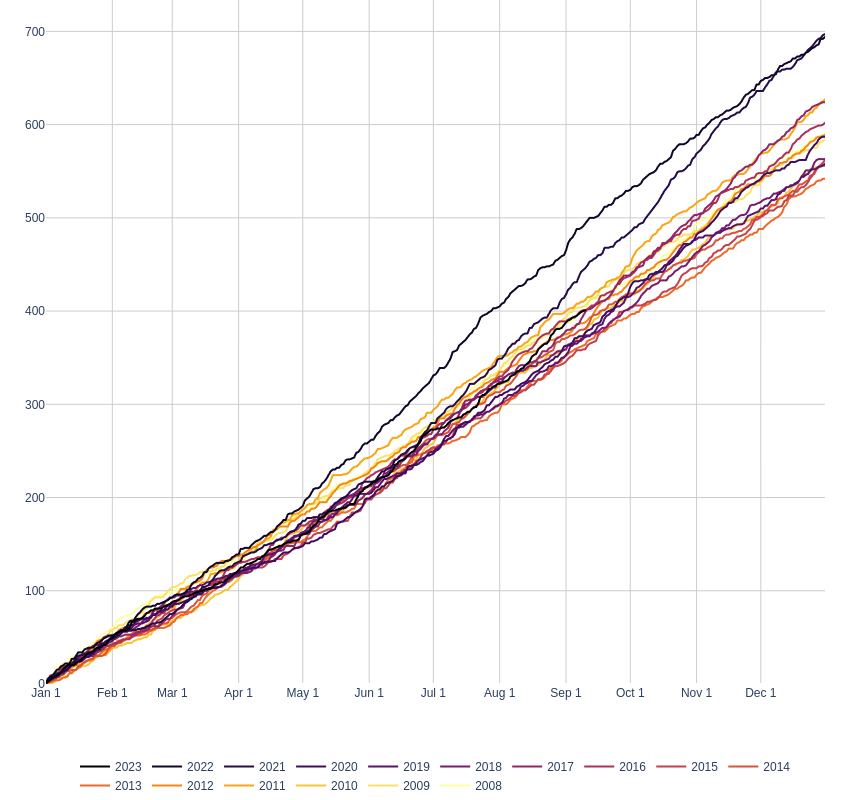

In [12]:
save(
    px.line(
        ytds,
        x='Text', y='YTD Deaths', color='Year',
        color_discrete_sequence=year_colors,
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=month_starts,
        ticktext=month_starts,
    ),
    legend=dict(traceorder='reversed',),
    #bottom_legend=False,
    title='YTD Traffic Deaths',
    name='ytd-deaths',
    hoverx='x',
    bg='white',
    ygrid='#ccc',
    xgrid='#ccc',
    w=850,
    h=800,
)

### Group by year

In [13]:
dt = crashes.dt.dt
fatalities_per_year = crashes.FATALITIES.groupby(dt.year).sum().astype(int).rename('NJSP records')

#### NJSP reports a "total deaths" that is typically ≈5% higher than the crash records' total

In [14]:
njsp_totals = totals.fatalities.rename('NJSP total')
njsp_diff = (totals.fatalities - fatalities_per_year).rename('NJSP diff')
njsp_totals = sxs(
    fatalities_per_year,
    njsp_totals,
    njsp_diff,
    round(njsp_diff / njsp_totals * 100, 1).apply(lambda pct: f'{"+" if pct >= 0 else "-"}{pct}%').rename('NJSP diff %'),
)
njsp_totals

,NJSP records,NJSP total,NJSP diff,NJSP diff %
2008,590,590,0,+0.0%
2009,584,584,0,+0.0%
2010,556,556,0,+0.0%
2011,627,627,0,+0.0%
2012,589,589,0,+0.0%
2013,542,542,0,+0.0%
2014,556,556,0,+0.0%
2015,562,562,0,+0.0%
2016,602,602,0,+0.0%
2017,624,624,0,+0.0%


### Group by month

In [15]:
ym = crashes.dt.apply(lambda d: d.strftime('%Y-%m')).rename('ym')
ym

0       2008-01
1       2008-01
2       2008-01
3       2008-01
4       2008-01
         ...   
8779    2023-09
8780    2023-09
8781    2023-09
8782    2023-09
8783    2023-09
Name: ym, Length: 8784, dtype: object

In [16]:
fatalities_per_month = crashes[crashes.dt < cur_month].FATALITIES.groupby(ym).sum()
fatalities_per_month

ym
2008-01    59.0
2008-02    40.0
2008-03    33.0
2008-04    50.0
2008-05    46.0
           ... 
2023-04    39.0
2023-05    52.0
2023-06    62.0
2023-07    49.0
2023-08    63.0
Name: FATALITIES, Length: 188, dtype: float64

### Rolling avg

In [17]:
rolling = fatalities_per_month.rolling(12).mean()
rolling

ym
2008-01          NaN
2008-02          NaN
2008-03          NaN
2008-04          NaN
2008-05          NaN
             ...    
2023-04    55.333333
2023-05    53.916667
2023-06    53.333333
2023-07    51.000000
2023-08    51.583333
Name: FATALITIES, Length: 188, dtype: float64

In [18]:
mos = (
    sxs(
        dt.year.rename('year'),
        dt.month.rename('month'),
        crashes.FATALITIES,
    )
    .groupby(['year', 'month']).sum()
)
mos

FATALITIES
year month            
2008 1            59.0
     2            40.0
     3            33.0
     4            50.0
     5            46.0
...                ...
2023 5            52.0
     6            62.0
     7            49.0
     8            63.0
     9            16.0

[189 rows x 1 columns]

In [19]:
pivoted = mos.reset_index().sort_values(['month', 'year'])
pivoted = pivoted[pivoted.apply(lambda r: to_dt('%d-%02d' % (r.year, r.month)).tz_localize(cur_month_dt.tz) < cur_month_dt, axis=1)]
pivoted

,year,month,FATALITIES
0,2008,1,59.0
12,2009,1,57.0
24,2010,1,37.0
36,2011,1,36.0
48,2012,1,52.0
...,...,...,...
131,2018,12,47.0
143,2019,12,51.0
155,2020,12,47.0
167,2021,12,61.0


In [20]:
by_month = crashes.FATALITIES.groupby([dt.year, dt.month]).sum()
by_month

dt    dt
2008  1     59.0
      2     40.0
      3     33.0
      4     50.0
      5     46.0
            ... 
2023  5     52.0
      6     62.0
      7     49.0
      8     63.0
      9     16.0
Name: FATALITIES, Length: 189, dtype: float64

### Break out victim "types"

Check victim "type" subtotals vs. total:

In [21]:
fatal_totals = sxs(*[crashes[f'FATAL_{t}'].fillna(0) for t in 'DTPB']).sum(axis=1)
sxs(crashes.dt, (crashes.FATALITIES - fatal_totals).rename('diff')).groupby(dt.year)['diff'].sum()

dt
2008    590.0
2009    584.0
2010    556.0
2011    627.0
2012    589.0
2013    542.0
2014    556.0
2015    562.0
2016    602.0
2017    624.0
2018    563.0
2019    558.0
2020      0.0
2021      0.0
2022      0.0
2023      0.0
Name: diff, dtype: float64

Cross-reference with annual totals, populate "unknown" subtotal:

In [22]:
type_cols_map = {
    'FATAL_D': 'Drivers',
    'FATAL_T': 'Pedestrians',
    'FATAL_P': 'Passengers',
    'FATAL_B': 'Cyclists',
}
type_cols = list(type_cols_map.keys())

In [23]:
type_cols

['FATAL_D', 'FATAL_T', 'FATAL_P', 'FATAL_B']

In [24]:
year_type_sums = (
    sxs(
        crashes.dt,
        crashes[type_cols].fillna(0)
    )
    .groupby(dt.year.rename('year'))
    [type_cols]
    .sum()
    .astype(int)
)

year_sums = year_type_sums.sum(axis=1).rename('sum')
year_totals = totals.fatalities.rename('Total')
missing = njsp_totals['NJSP diff'].rename('Missing')
unknown = (year_totals - year_sums - missing).rename('FATAL_U')

type_cols_map['FATAL_U'] = 'Unknown'
type_cols = list(type_cols_map.keys())

year_types = (
    sxs(
        year_type_sums,
        year_sums,
        year_totals,
        unknown,
        missing,
    )
    [ type_cols + [ 'Missing', 'Total', ] ]
    .rename(columns=type_cols_map)
)
value_cols = list(type_cols_map.values())
year_types

,Drivers,Pedestrians,Passengers,Cyclists,Unknown,Missing,Total
2008,0,0,0,0,590,0,590
2009,0,0,0,0,584,0,584
2010,0,0,0,0,556,0,556
2011,0,0,0,0,627,0,627
2012,0,0,0,0,589,0,589
2013,0,0,0,0,542,0,542
2014,0,0,0,0,556,0,556
2015,0,0,0,0,562,0,562
2016,0,0,0,0,602,0,602
2017,0,0,0,0,624,0,624


In [25]:
assert (missing == 0).all()

In [26]:
year_types = year_types.drop(columns='Missing')

In [27]:
total_errors = sxs(year_types.Total, njsp_totals['NJSP total'])[year_types.Total != njsp_totals['NJSP total']]
total_errors

,Total,NJSP total


In [28]:
assert total_errors.empty, total_errors

In [29]:
year_types['Projected'] = 0
prv_year = cur_year - 1
cur_total = year_types.loc[cur_year, 'Total']
prv_total = year_types.loc[prv_year, 'Total']
projected_total = prv_total * prv_ytd_ratio
#projected_total = cur_total * prv_roy_ratio
projected_remaining = int(projected_total - cur_total)
year_types.loc[cur_year, 'Projected'] = projected_remaining
year_types['Projected Total'] = year_types.Total + year_types.Projected

In [30]:
year_types

,Drivers,Pedestrians,Passengers,Cyclists,Unknown,Total,Projected,Projected Total
2008,0,0,0,0,590,590,0,590
2009,0,0,0,0,584,584,0,584
2010,0,0,0,0,556,556,0,556
2011,0,0,0,0,627,627,0,627
2012,0,0,0,0,589,589,0,589
2013,0,0,0,0,542,542,0,542
2014,0,0,0,0,556,556,0,556
2015,0,0,0,0,562,562,0,562
2016,0,0,0,0,602,602,0,602
2017,0,0,0,0,624,624,0,624


In [31]:
total_2021 = year_types.loc[2021, 'Total']
total_2022 = year_types.loc[2022, 'Total']
projected_total_2023 = year_types.loc[2023, 'Projected Total']

In [32]:
with open(f'{PLOTS_DIR}/projected_totals.json', 'w') as f:
    json.dump(year_types.dropna().to_dict('index'), f, indent=4,)

### Fatalities per year (by type)

In [33]:
ytc = colors_lengthen(px_colors, 9)

def avg(c1, c2):
    return (RGB.from_css(c1) + RGB.from_css(c2) / 2).css

idx = 1
#unknown_color = '#2a2a2a'
#unknown_color = avg(ytc[idx-1], ytc[idx])
#ytc = ytc[:idx] + [unknown_color] + ytc[idx:]
#missing_color = '#666'
#ytc = [missing_color] + ytc
print(' '.join(ytc))

swatches(ytc)

#000004 #200c46 #55106b #882268 #ba3853 #e15b31 #f78e0d #f7ca36 #fcffa4


<span style="font-family: monospace">#000004 <span style="color: #000004">██████</span></span> <span style="font-family: monospace">#200c46 <span style="color: #200c46">██████</span></span> <span style="font-family: monospace">#55106b <span style="color: #55106b">██████</span></span> <span style="font-family: monospace">#882268 <span style="color: #882268">██████</span></span> <span style="font-family: monospace">#ba3853 <span style="color: #ba3853">██████</span></span> <span style="font-family: monospace">#e15b31 <span style="color: #e15b31">██████</span></span> <span style="font-family: monospace">#f78e0d <span style="color: #f78e0d">██████</span></span> <span style="font-family: monospace">#f7ca36 <span style="color: #f7ca36">██████</span></span> <span style="font-family: monospace">#fcffa4 <span style="color: #fcffa4">██████</span></span>

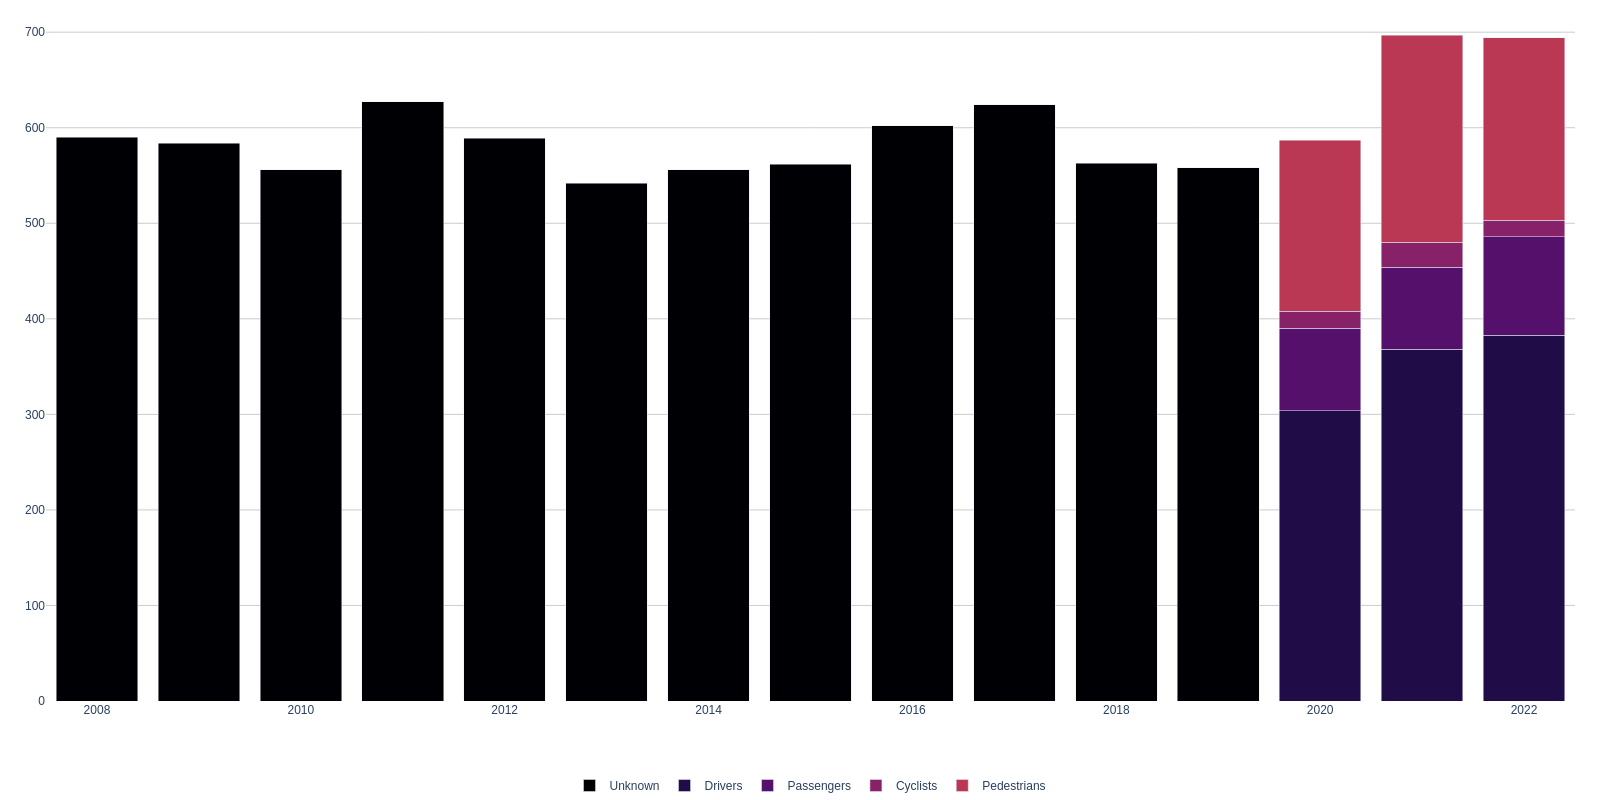

In [34]:
type_labels_map = [
    'Unknown',
    'Drivers',
    'Passengers',
    'Cyclists',
    'Pedestrians',
    'Projected',
]
fig = (
    px.bar(
        year_types[year_types.index < 2023][type_labels_map].drop(columns='Projected').replace(0, nan),
        barmode='stack',
        color_discrete_sequence=ytc,
    )
    .update_yaxes(gridcolor=gridcolor)
)
save(
    fig,
    title=f'NJ Traffic Deaths per Year (by victim type)<br><sup>2021 and 2022 were the deadliest years in the NJSP record, with {total_2021} and {total_2022} traffic fatalities, resp.',
    name='fatalities_per_year_by_type',
    hoverx=True,
    w=1600,
    h=800,
)

### Fatalities per month (by victim type)

In [35]:
crash_type_cols = [ col for col in type_cols if col != 'FATAL_U' ]
month_types = (
    sxs(
        crashes.dt,
        crashes[crash_type_cols].fillna(0)
    )
    [ dt.year >= 2020 ]
    .groupby([
        dt.year.rename('year'),
        dt.month.rename('month'),
    ])
    [crash_type_cols]
    .sum()
    .astype(int)
)

month_types = month_types.reset_index()
month_types['dt'] = (
    month_types
    [['year', 'month']]
    .apply(lambda r: '%04d-%02d' % (r['year'], r['month']), axis=1)
)
month_types = month_types.set_index('dt').drop(columns=['year', 'month'])
month_types

,FATAL_D,FATAL_T,FATAL_P,FATAL_B
dt,,,,
2020-01,21,18,8,2
2020-02,15,17,2,0
2020-03,11,16,8,1
2020-04,17,8,2,1
2020-05,28,13,9,2
2020-06,30,8,9,0
2020-07,30,19,8,5
2020-08,31,8,14,1
2020-09,31,21,5,0


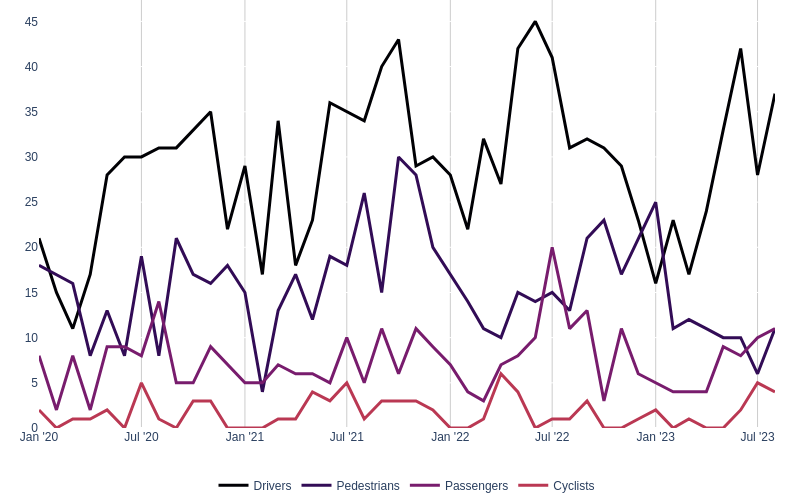

In [36]:
type_colors = colors_lengthen(px_colors, 7)

fig = px.line(
    month_types.rename(columns=type_cols_map).loc[to_dt(month_types.index) < cur_month],
    labels={'variable': '',},
    color_discrete_sequence=type_colors,
)
fig.update_traces(line=dict(width=3))
save(
    fig,
    title='NJ Traffic Deaths per Month (by victim type)',
    name='fatalities_per_month_by_type',
    hoverx=True,
    xgrid=gridcolor,
    xaxis=dict(
        tickformat="%b '%y",
    ),
    w=800,
)

### Fatalities per month

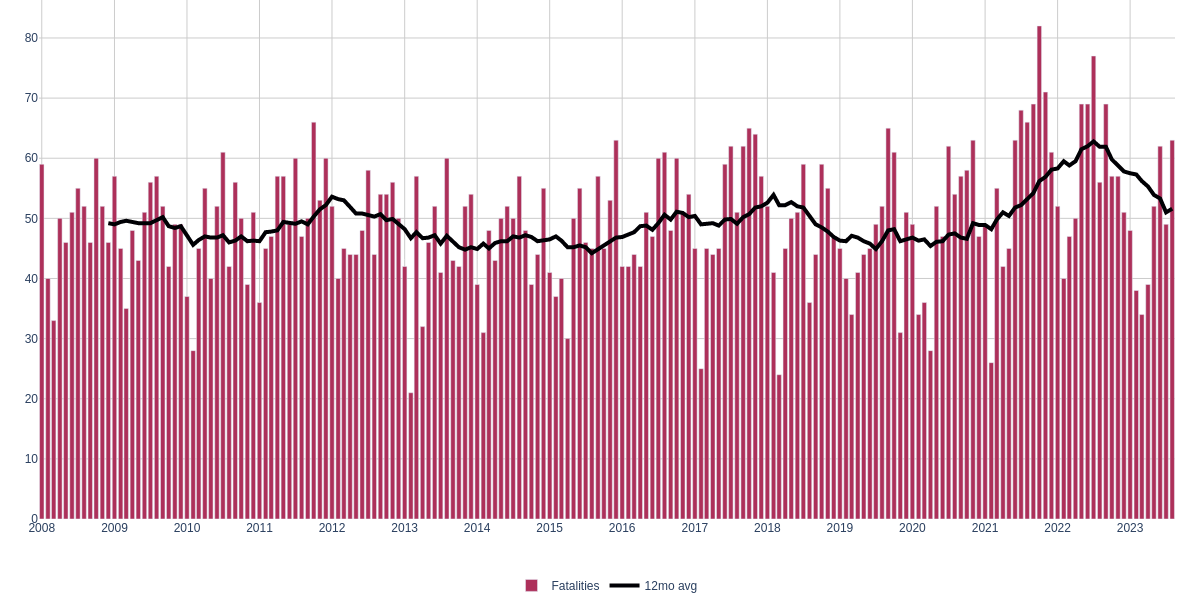

In [37]:
fig = go.Figure()
fig.add_trace(go.Bar(x=fatalities_per_month.index, y=fatalities_per_month.values, name='Fatalities', marker_color=red))
fig.add_trace(go.Scatter(x=rolling.index, y=rolling.apply(partial(round, ndigits=1)), name='12mo avg', line={'width': 4, 'color': black, }))
save(
    fig,
    title='NJ Traffic Deaths per Month',
    name='fatalities_per_month',
    hoverx=True,
    xaxis=dict(
        tickmode = 'array',
        tickvals = years.tolist(),
        ticktext = years.tolist(),
    ),
    grid=gridcolor,
    w=1200, h=600,
)

In [38]:
month_names = [ to_dt('2022-%02d' % i).strftime('%b') for i in range(1, 13) ]
print(' '.join(month_names))

Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec


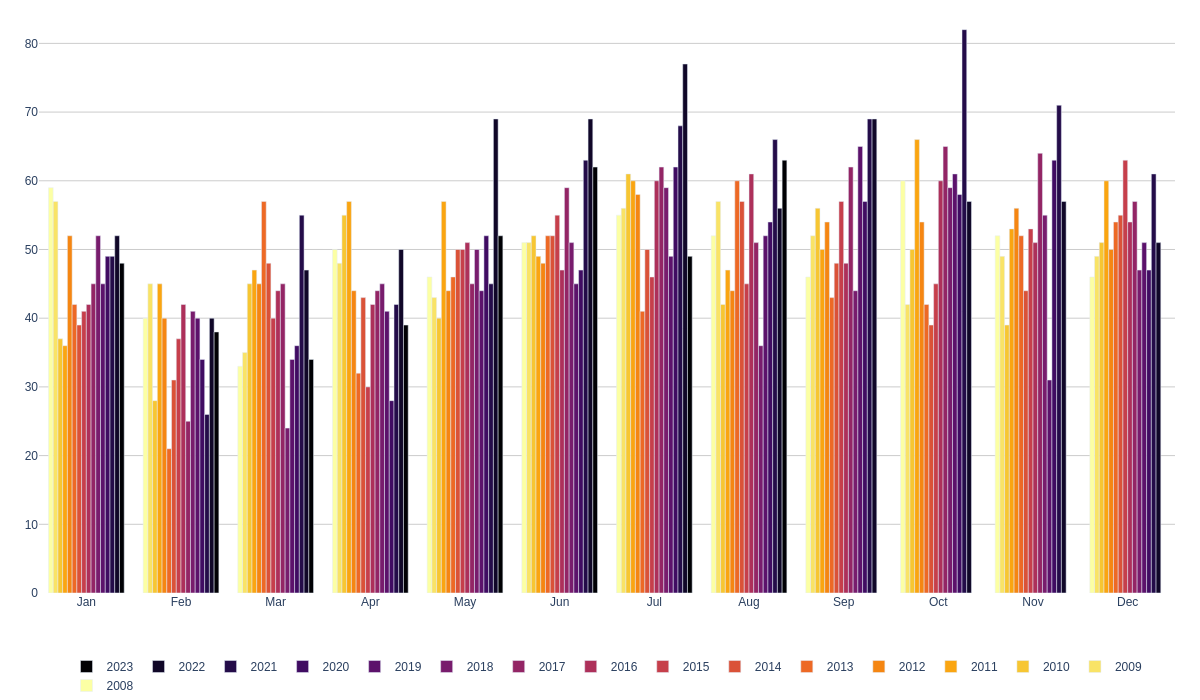

In [39]:
fig = px.bar(
    x = pivoted.month,
    y = pivoted.FATALITIES,
    color = pivoted.year.astype(str),
    color_discrete_sequence=year_colors,
    labels=dict(color='', x='', y='',),
    barmode='group',
).update_yaxes(
    gridcolor=gridcolor,
)
save(
    fig,
    title='NJ Traffic Deaths, by Month',
    name='fatalities_by_month_bars',
    legend=dict(traceorder='reversed'),
    xaxis=dict(
        tickmode = 'array',
        tickvals = list(range(1, 13)),
        ticktext = month_names,
    ),
    hoverx=True,
    w=1200, h=700,
)

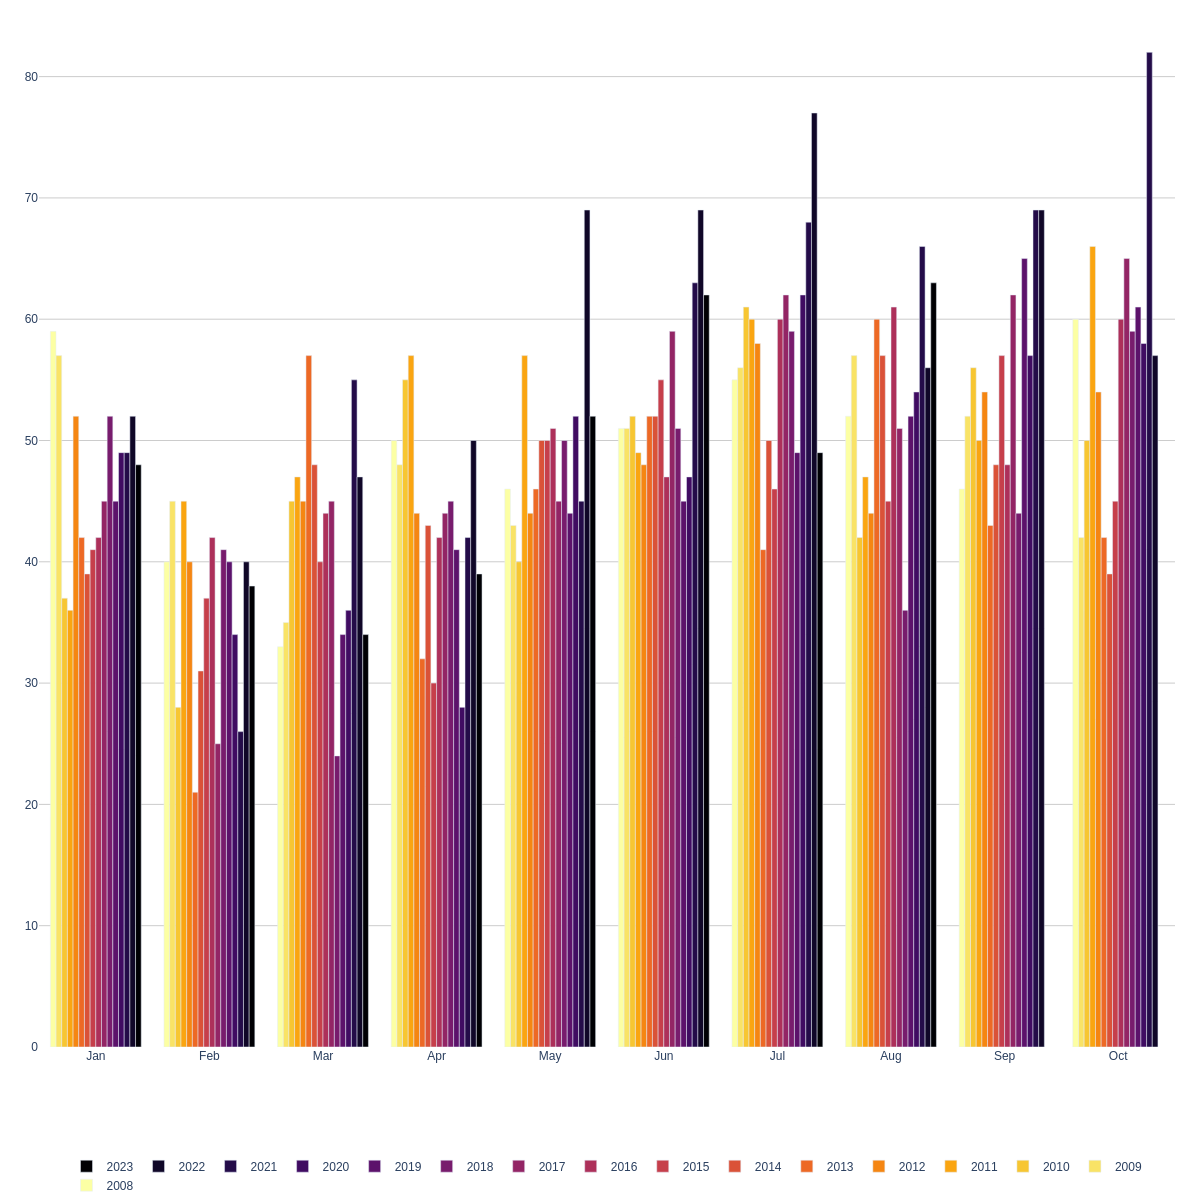

In [40]:
sq_month_cutoff = 10
end_mon = to_dt(f'{sq_month_cutoff}/1/2023').strftime('%b')
h1 = pivoted[pivoted.month <= sq_month_cutoff]
fig = px.bar(
    x = h1.month,
    y = h1.FATALITIES,
    color = h1.year.astype(str),
    color_discrete_sequence=year_colors,
    labels=dict(color='', x='', y='',),
    barmode='group',
).update_yaxes(
    gridcolor=gridcolor,
)
save(
    fig,
    title=f'NJ Traffic Deaths, by Month (Jan-{end_mon})',
    name='fatalities_by_month_bars_sq',
    legend=dict(traceorder='reversed'),
    xaxis=dict(
        tickmode = 'array',
        tickvals = list(range(1, sq_month_cutoff+1)),
        ticktext = month_names,
    ),
    hoverx=True,
    w=1200, h=1200,
)

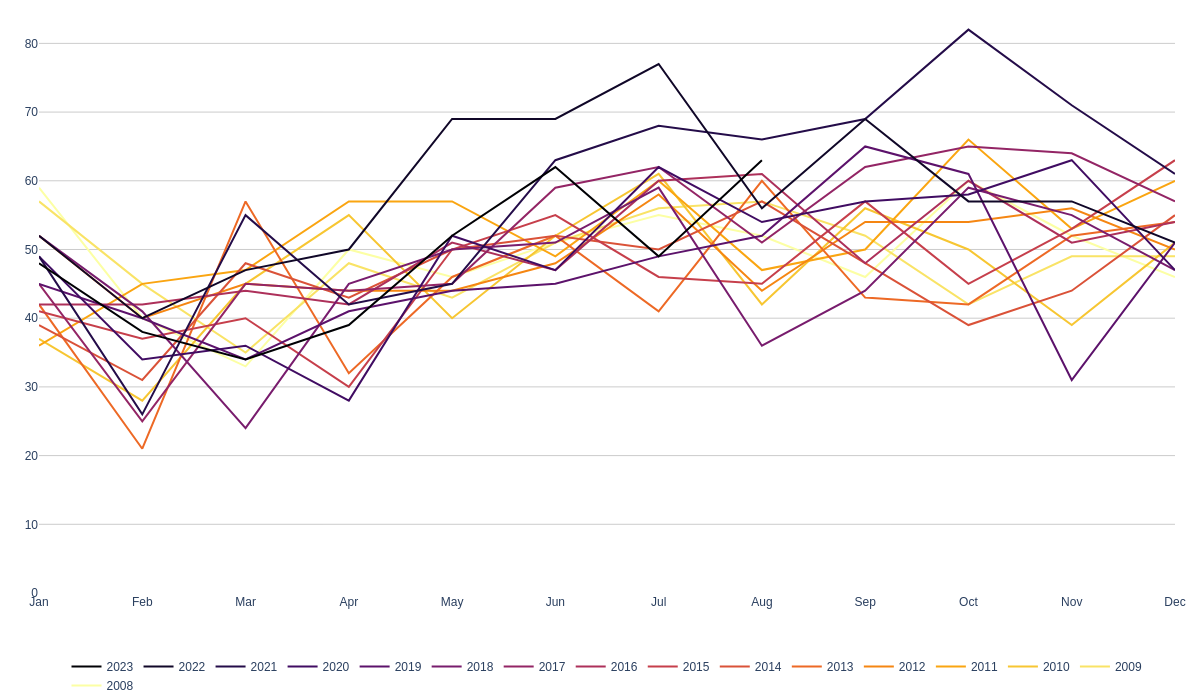

In [41]:
fig = px.line(
    x = pivoted.month,
    y = pivoted.FATALITIES,
    color = pivoted.year,
    color_discrete_sequence=year_colors,
    labels={ 'color': '', 'x': '', 'y': '' },
).update_yaxes(
    gridcolor=gridcolor,
)
save(
    fig,
    title='NJ Traffic Deaths by Month',
    name='fatalities_by_month_lines',
    xaxis=dict(
        tickmode = 'array',
        tickvals = list(range(1, 13)),
        ticktext = month_names,
    ),
    legend=dict(traceorder='reversed'),
    hoverx=True,
    w=1200, h=700,
)